In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import glob
from pathlib import Path

In [2]:
def plot_images_grid(images_path, images_per_row=3, figsize=(20, 10), process_fn=None):
    """
    Plots (optionally processed) images from a given folder path in a grid format.

    Args:
        images_path (str or Path): Path to the folder containing images.
        images_per_row (int, optional): Number of images per row. Default is 3.
        figsize (tuple, optional): Size of the figure. Default is (20, 10).
        process_fn (function, optional): Function that takes an Image and returns a processed Image.
    """
    images_path = Path(images_path)
    image_paths = [p for p in images_path.iterdir() if p.suffix.lower() in [".png", ".jpg", ".jpeg", ".bmp", ".gif", ".tiff"]]

    if not image_paths:
        print("No images found in the specified directory.")
        return

    num_images = len(image_paths)
    num_rows = (num_images + images_per_row - 1) // images_per_row

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(figsize[0], figsize[1] * num_rows))
    axes = axes.flatten()

    for idx, image_path in enumerate(image_paths):
        image = Image.open(image_path)

        if process_fn:
            image = process_fn(image)  

        axes[idx].imshow(image)
        axes[idx].axis('off')
        axes[idx].set_title(image_path.name)

    for idx in range(len(image_paths), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

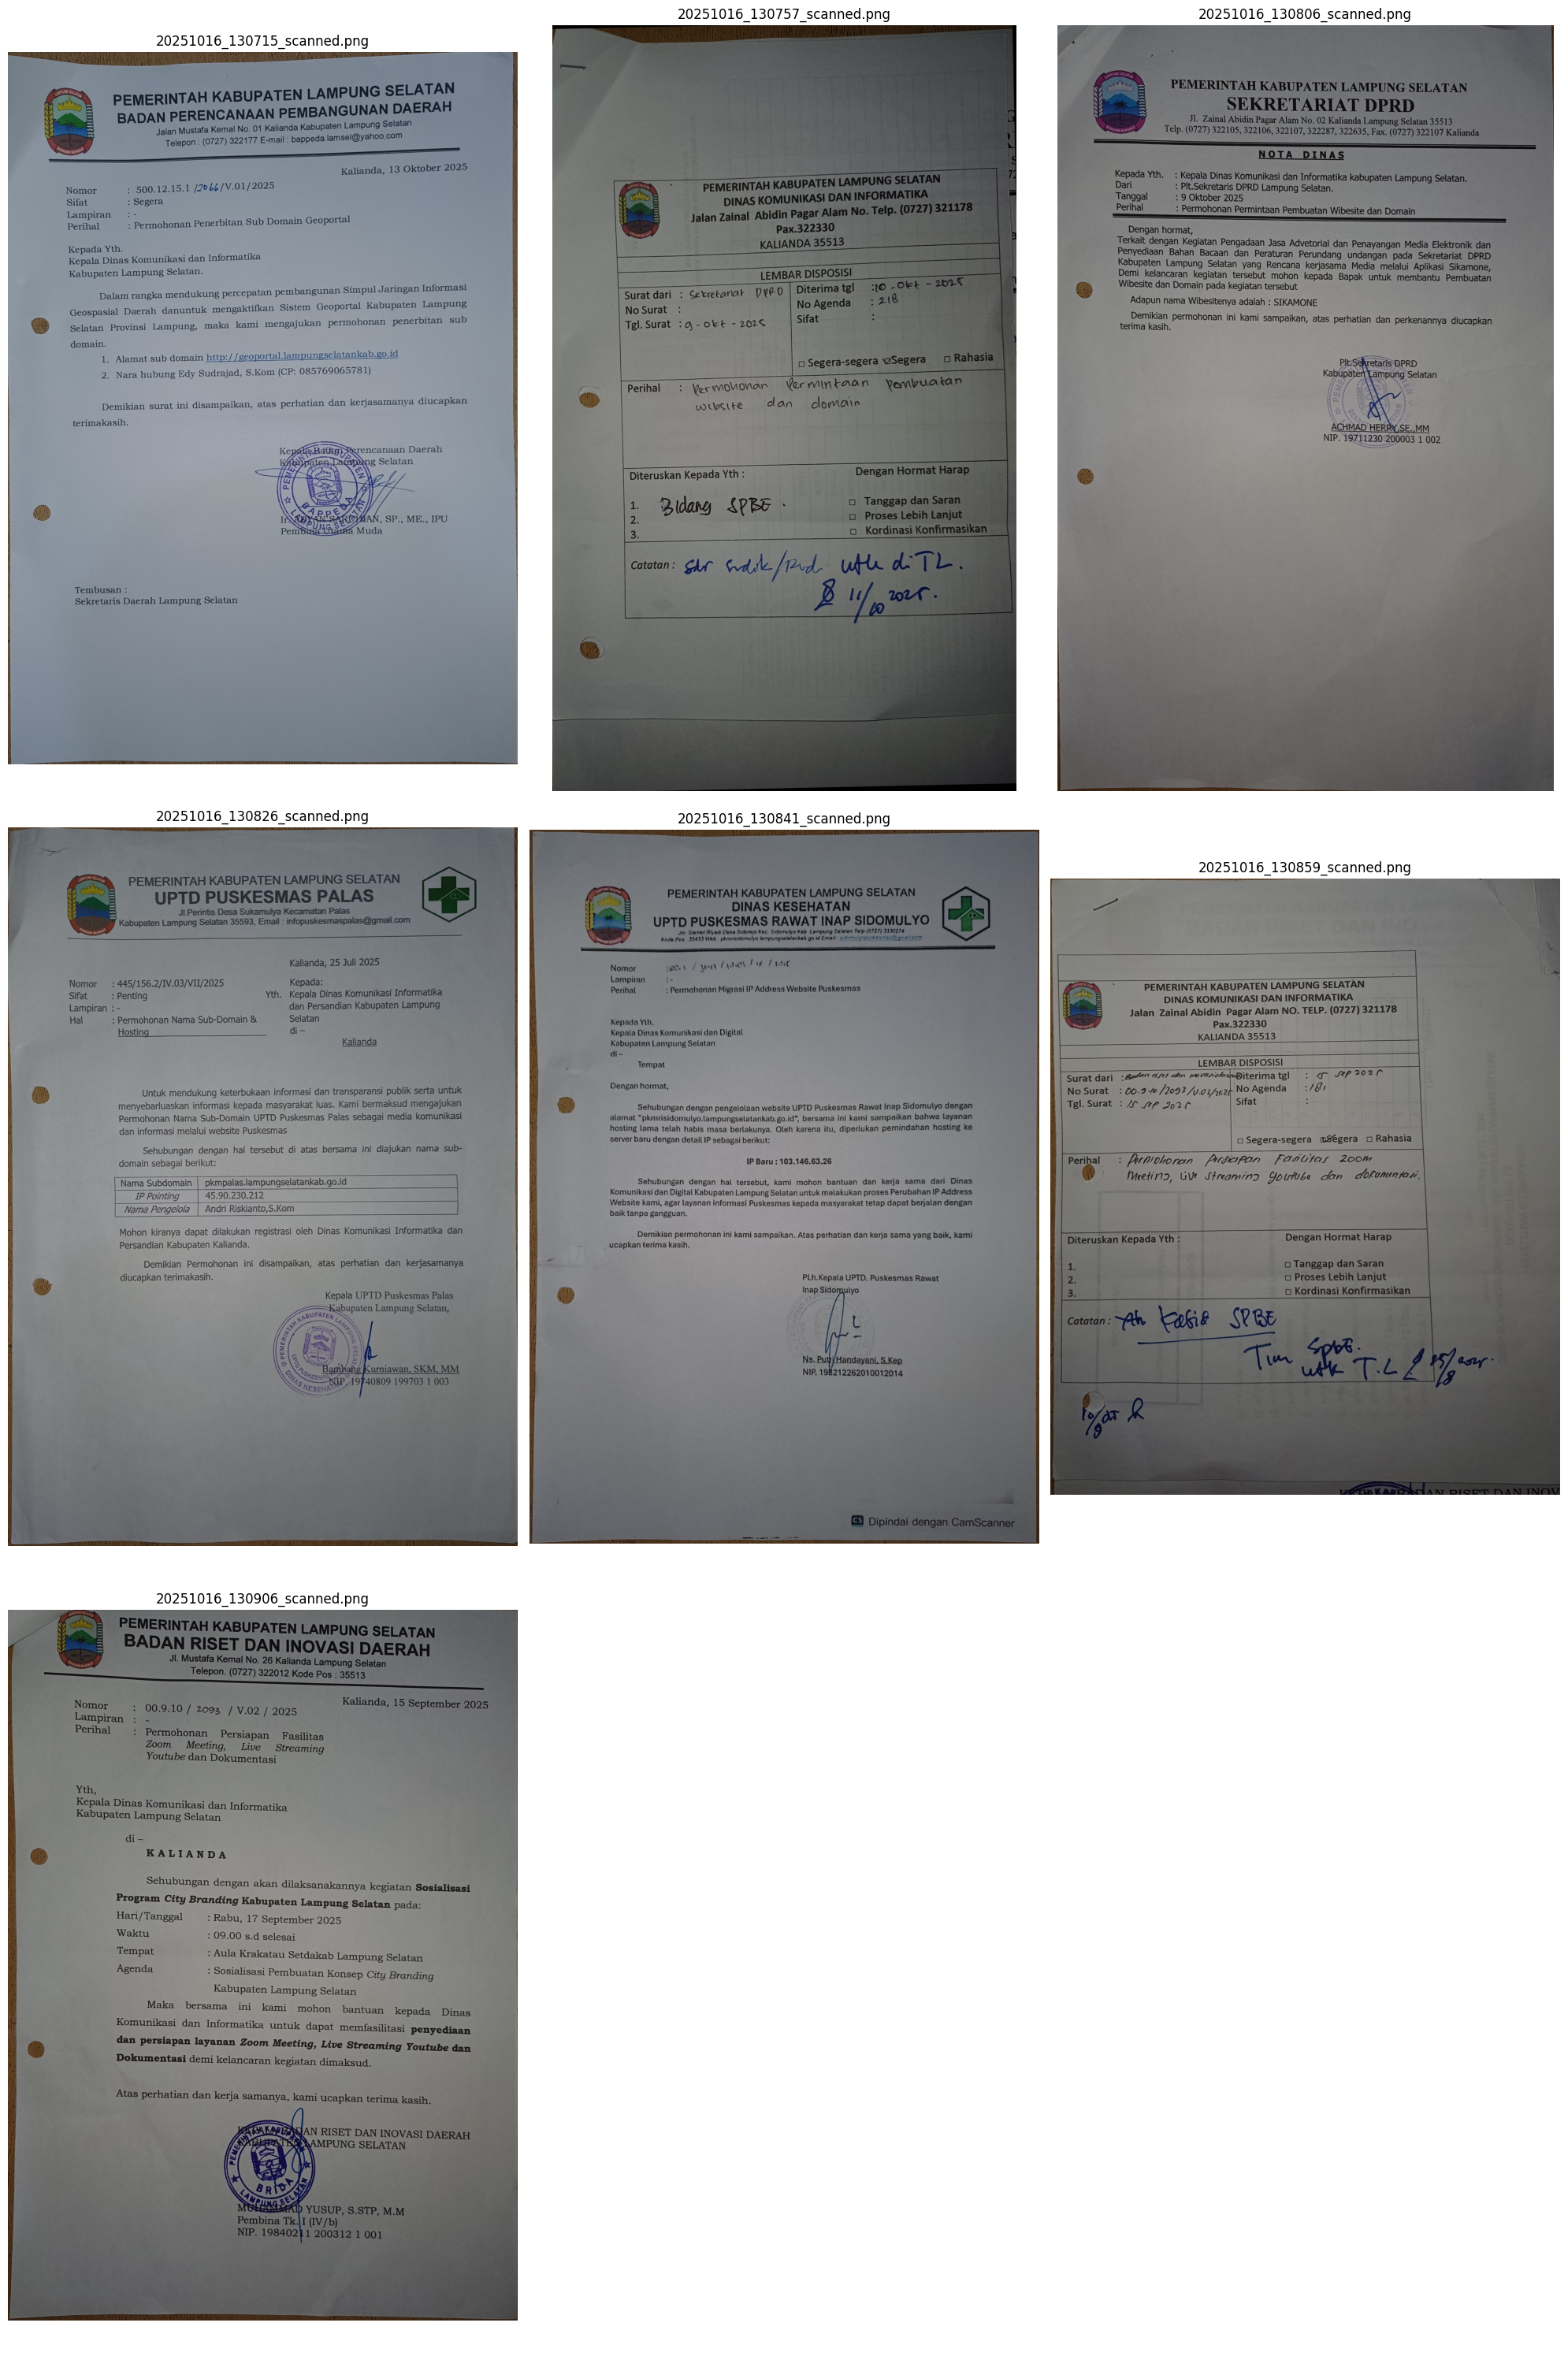

In [3]:
image_path = "scanned_results_6"
plot_images_grid(image_path, images_per_row=3, figsize=(20, 10))

In [6]:
import cv2
import numpy as np
import PIL.ImageEnhance as ImageEnhance

In [7]:
def preprocess_image(image):
    """
    Preprocesses an image: converts to grayscale, applies denoising,
    enhances contrast and sharpness, then corrects orientation.
    """
    gray = np.array(image.convert("L"))
    mean_intensity = np.mean(gray)
    if mean_intensity < 10:
        print("The image appears to be blackened. Skipping further processing.")
        return image
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    if laplacian_var < 100:
        blurred_correction = cv2.GaussianBlur(gray, (5, 5), 0)
        gray = cv2.addWeighted(gray, 1.5, blurred_correction, -0.5, 0)
    denoised = cv2.fastNlMeansDenoising(gray, None, 7, 7, 21)
    processed_image = Image.fromarray(denoised)
    processed_image = ImageEnhance.Contrast(processed_image).enhance(1.3)
    processed_image = ImageEnhance.Sharpness(processed_image).enhance(1.8)

    # 👇 final conversion to display compatibility
    processed_image = processed_image.convert("RGB")

    return processed_image

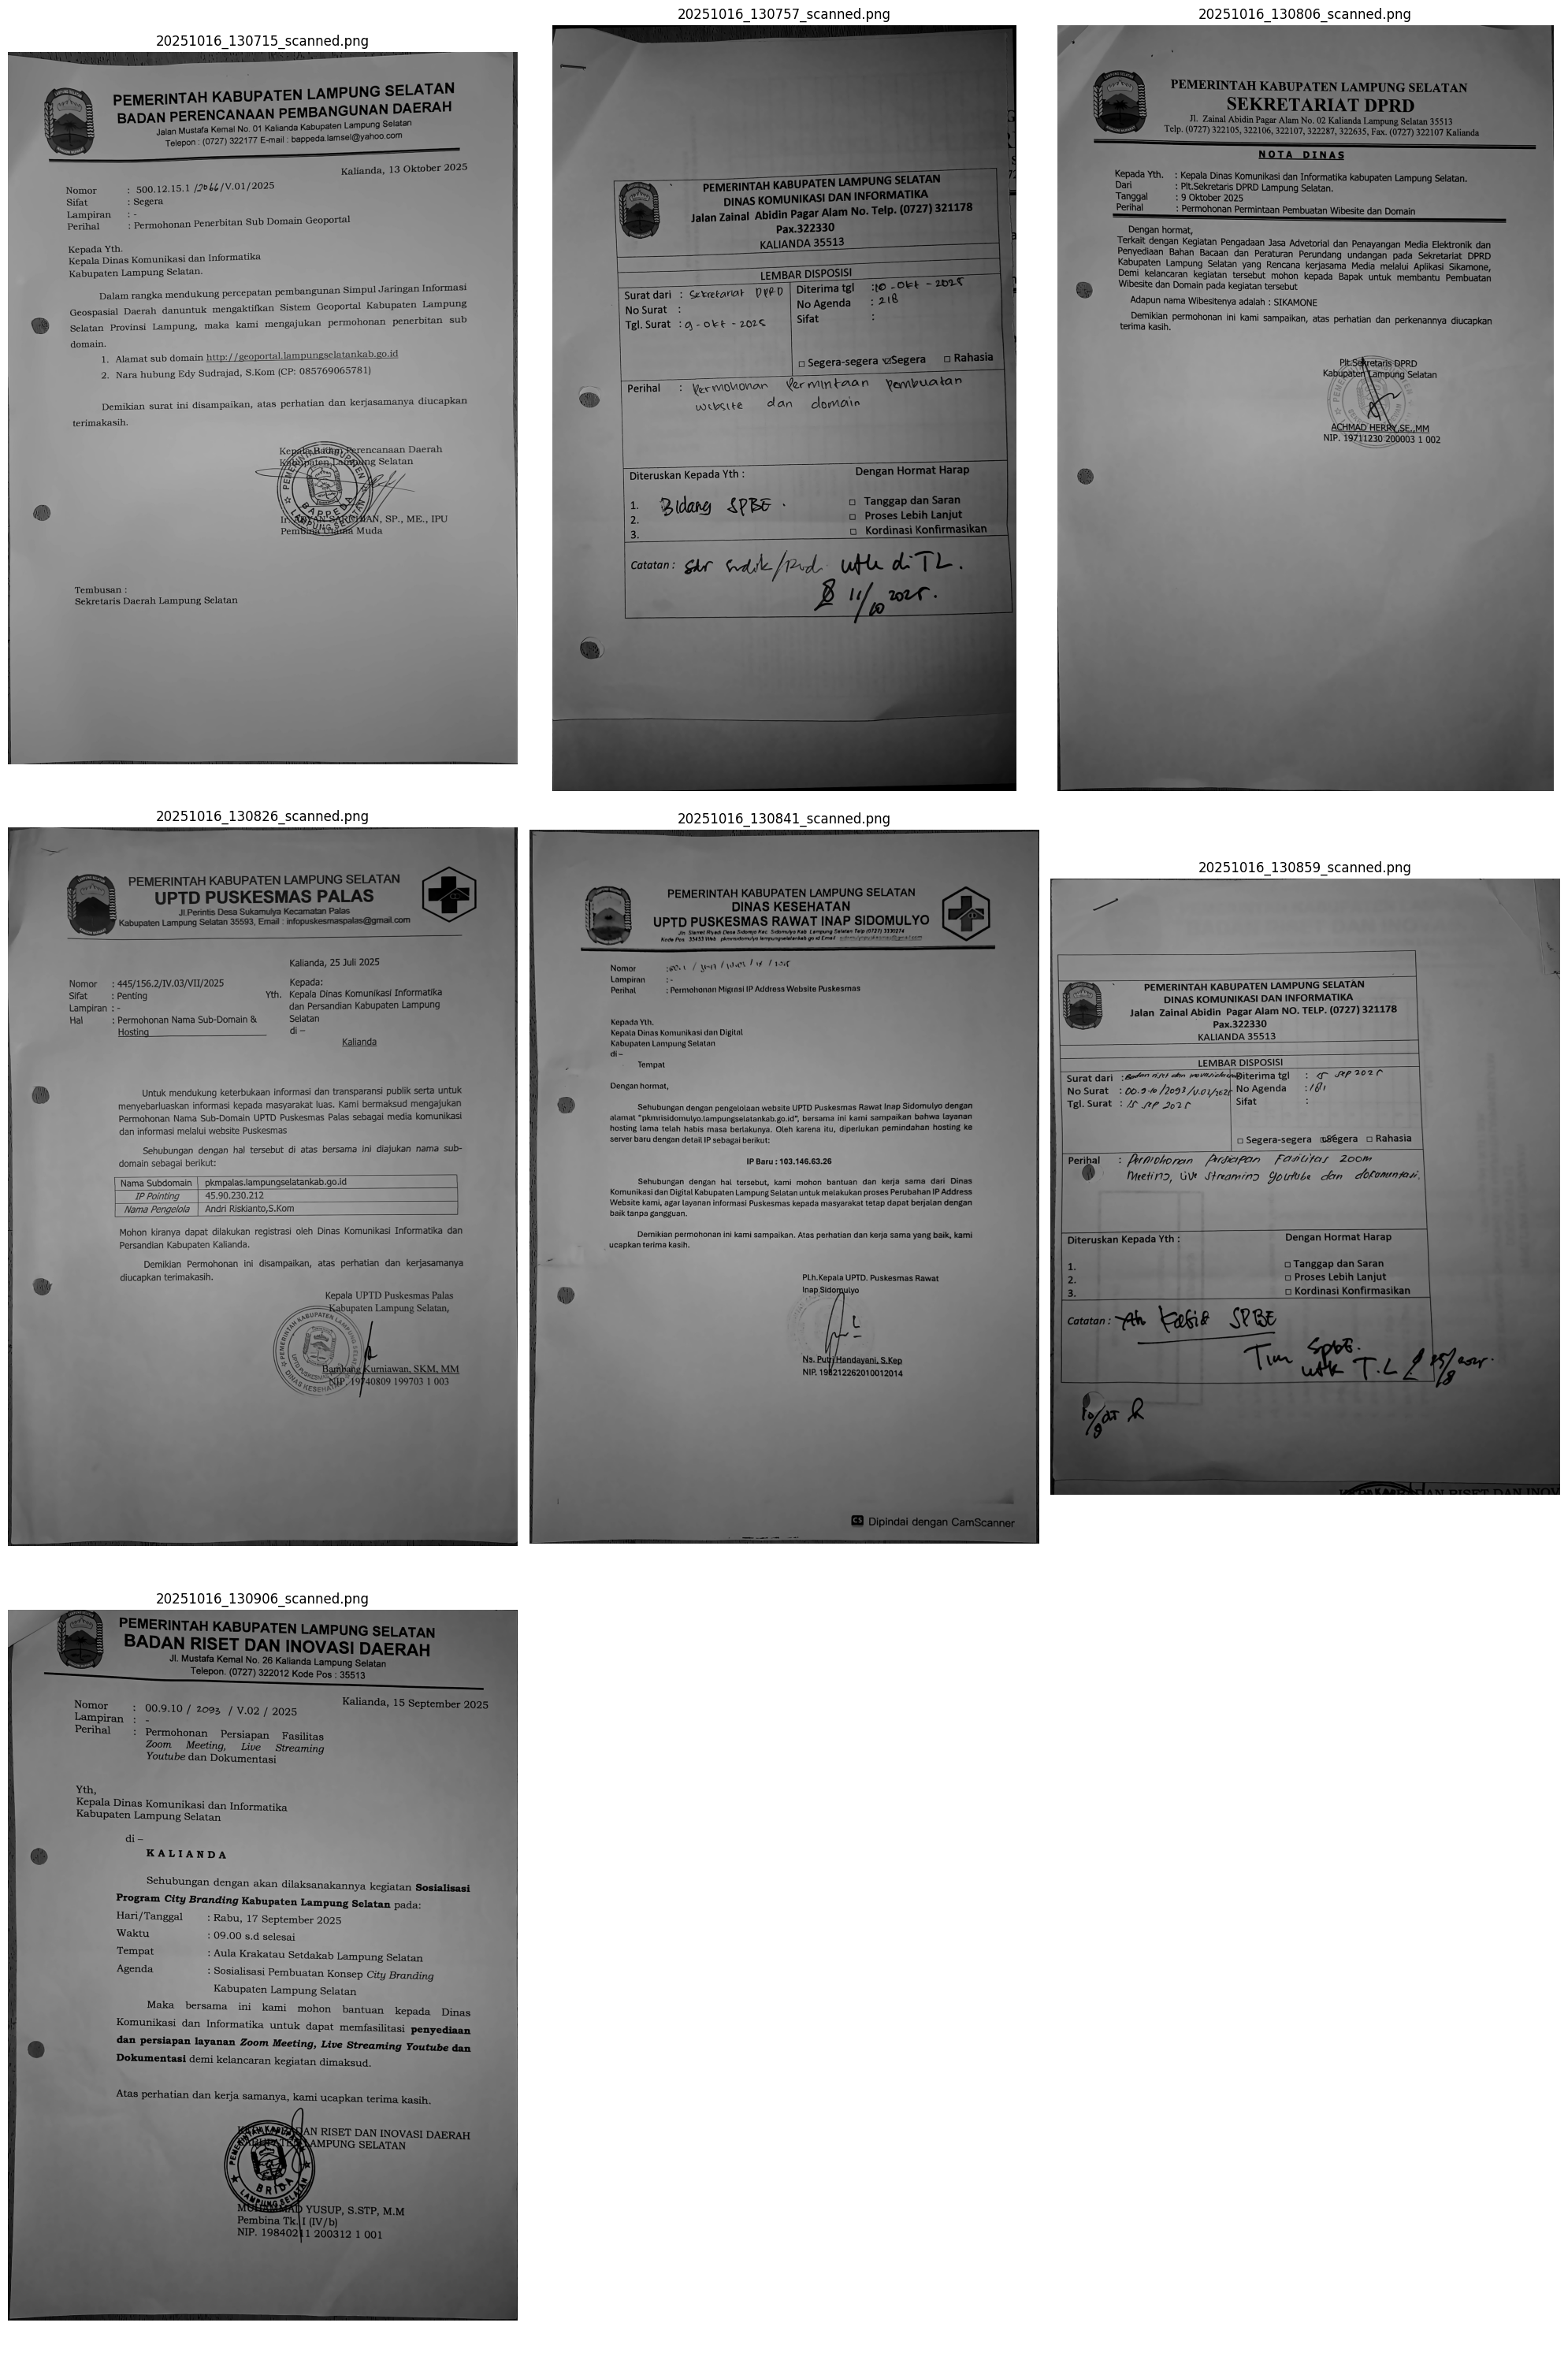

In [8]:
image_path = "scanned_results_6"
plot_images_grid(image_path, process_fn=preprocess_image)


In [9]:
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, ImageFormatOption
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode

from docling_core.types.doc import DoclingDocument
from docling_core.types.doc.document import DocTagsDocument

c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime r

In [14]:
import os

# On Windows, disable Hugging Face Hub symlinks to avoid permission errors (WinError 1314)
# This forces the hub to copy files instead of creating symlinks.
os.environ["HF_HUB_DISABLE_SYMLINKS"] = "1"

# Configure pipeline options
pipeline_options = PdfPipelineOptions(do_table_structure=True)
pipeline_options.table_structure_options.mode = TableFormerMode.ACCURATE

# Initialize the document converter once
doc_converter = DocumentConverter(
    format_options={InputFormat.IMAGE: ImageFormatOption(pipeline_options=pipeline_options)},
    allowed_formats=[InputFormat.IMAGE]
)

# Loop through all images
images_dir = Path(image_path)  # convert the existing string path to a Path
for image_file in images_dir.glob("*.png"):  # Ajuste selon tes fichiers (.jpg, .jpeg, etc.)
    print(f"Processing {image_file.name}...")

    # Convert the image
    conversion_result = doc_converter.convert(source=image_file)

    # Export the text
    text_output = conversion_result.document.export_to_text()

    # Print extracted text
    # print("\nExtracted Text:")
    # print(text_output)
    # print("=" * 80)
    # Save the text to a file
    output_text_file = images_dir / f"{image_file.stem}_output.txt"
    with open(output_text_file, "w", encoding="utf-8") as f:
        f.write(text_output)
        

2025-10-21 09:04:20,048 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]


2025-10-21 09:04:20,189 - INFO - Going to convert document batch...
2025-10-21 09:04:20,190 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 4f2edc0f7d9bb60b38ebfecf9a2609f5
2025-10-21 09:04:20,192 - INFO - rapidocr cannot be used because onnxruntime is not installed.
2025-10-21 09:04:20,194 - INFO - easyocr cannot be used because it is not installed.
2025-10-21 09:04:20,195 - INFO - Accelerator device: 'cpu'
[INFO] 2025-10-21 09:04:20,214 [RapidOCR] base.py:22: Using engine_name: torch


Processing 20251016_130715_scanned.png...


[INFO] 2025-10-21 09:04:20,262 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.pth
[INFO] 2025-10-21 09:04:20,263 [RapidOCR] torch.py:54: Using C:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\rapidocr\models\ch_PP-OCRv4_det_infer.pth
[INFO] 2025-10-21 09:04:20,474 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-10-21 09:04:20,498 [RapidOCR] download_file.py:60: File exists and is valid: C:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\rapidocr\models\ch_ptocr_mobile_v2.0_cls_infer.pth
[INFO] 2025-10-21 09:04:20,499 [RapidOCR] torch.py:54: Using C:\Users\acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\rapidocr\models\ch_ptocr_mobile_v2.0_cls_infer.pth
[INFO] 2025-10-21 09:04:20,595 [RapidOCR] base.py:22: Using engine_name: torch
[INFO] 2025-10-21 09:04:20,680 [RapidOCR] download_file.py:60: File 

Processing 20251016_130757_scanned.png...


2025-10-21 09:04:39,198 - INFO - Going to convert document batch...
2025-10-21 09:04:39,199 - INFO - Processing document 20251016_130757_scanned.png
2025-10-21 09:04:55,264 - INFO - Finished converting document 20251016_130757_scanned.png in 16.37 sec.
2025-10-21 09:04:55,269 - WARNING - Parameter `strict_text` has been deprecated and will be ignored.
2025-10-21 09:04:55,272 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]


Processing 20251016_130806_scanned.png...


2025-10-21 09:04:55,500 - INFO - Going to convert document batch...
2025-10-21 09:04:55,502 - INFO - Processing document 20251016_130806_scanned.png
2025-10-21 09:05:11,235 - INFO - Finished converting document 20251016_130806_scanned.png in 15.96 sec.
2025-10-21 09:05:11,239 - WARNING - Parameter `strict_text` has been deprecated and will be ignored.
2025-10-21 09:05:11,242 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]
2025-10-21 09:05:11,423 - INFO - Going to convert document batch...
2025-10-21 09:05:11,424 - INFO - Processing document 20251016_130826_scanned.png


Processing 20251016_130826_scanned.png...


2025-10-21 09:05:31,352 - INFO - Finished converting document 20251016_130826_scanned.png in 20.11 sec.
2025-10-21 09:05:31,357 - WARNING - Parameter `strict_text` has been deprecated and will be ignored.
2025-10-21 09:05:31,360 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]
2025-10-21 09:05:31,557 - INFO - Going to convert document batch...
2025-10-21 09:05:31,558 - INFO - Processing document 20251016_130841_scanned.png


Processing 20251016_130841_scanned.png...


2025-10-21 09:05:47,659 - INFO - Finished converting document 20251016_130841_scanned.png in 16.30 sec.
2025-10-21 09:05:47,663 - WARNING - Parameter `strict_text` has been deprecated and will be ignored.
2025-10-21 09:05:47,666 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]


Processing 20251016_130859_scanned.png...


2025-10-21 09:05:47,883 - INFO - Going to convert document batch...
2025-10-21 09:05:47,885 - INFO - Processing document 20251016_130859_scanned.png
2025-10-21 09:06:03,717 - INFO - Finished converting document 20251016_130859_scanned.png in 16.05 sec.
2025-10-21 09:06:03,726 - WARNING - Parameter `strict_text` has been deprecated and will be ignored.
2025-10-21 09:06:03,729 - INFO - detected formats: [<InputFormat.IMAGE: 'image'>]


Processing 20251016_130906_scanned.png...


2025-10-21 09:06:04,008 - INFO - Going to convert document batch...
2025-10-21 09:06:04,009 - INFO - Processing document 20251016_130906_scanned.png
2025-10-21 09:06:23,092 - INFO - Finished converting document 20251016_130906_scanned.png in 19.36 sec.
2025-10-21 09:06:23,097 - WARNING - Parameter `strict_text` has been deprecated and will be ignored.
